In [3]:
!pip install --upgrade librosa

In [4]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#Sample Sound (Children Playing)
filename = "6902-2-0-7.wav"

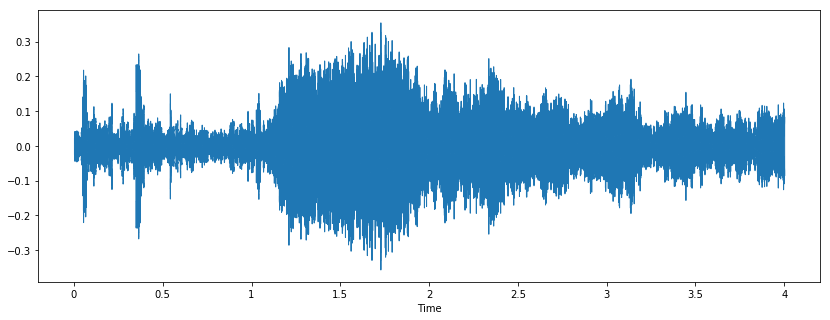

In [6]:

plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

**SAMPLE RATE**

Sample rate is the number of samples per second that are taken of a waveform to create a discete digital signal. The higher the sample rate, the more snapshots you capture of the audio signal. 

In [7]:
sample_rate

22050

In [8]:
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio = wav.read(filename)

In [9]:
wave_sample_rate

22050

In [10]:
wave_audio

array([[1764, -261],
       [1731, -183],
       [1590, -205],
       ...,
       [-676, -676],
       [ 244, 1133],
       [1232, 1950]], dtype=int16)

In [11]:
data

array([ 0.02293396,  0.02362061,  0.02113342, ..., -0.02062988,
        0.02101135,  0.04855347], dtype=float32)

We can observe for librosa the values of the data are normalized but by using scipy library the values are not sampled, so its better to use **librosa**.

In [12]:
import pandas as pd

metadata = pd.read_csv("UrbanSound8K.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
#Checking dataset

metadata["class"].value_counts()

jackhammer          1000
drilling            1000
children_playing    1000
engine_idling       1000
air_conditioner     1000
street_music        1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

**Audio Classification Pre-Processing.**

In [14]:
librosa_audio_data,librosa_sample_rate = librosa.load(filename)

In [15]:
print(librosa_audio_data) # Librosa converts audio into mono channel.

[ 0.02293396  0.02362061  0.02113342 ... -0.02062988  0.02101135
  0.04855347]


In [16]:
wave_audio #Wave_audio have dual channel

array([[1764, -261],
       [1731, -183],
       [1590, -205],
       ...,
       [-676, -676],
       [ 244, 1133],
       [1232, 1950]], dtype=int16)

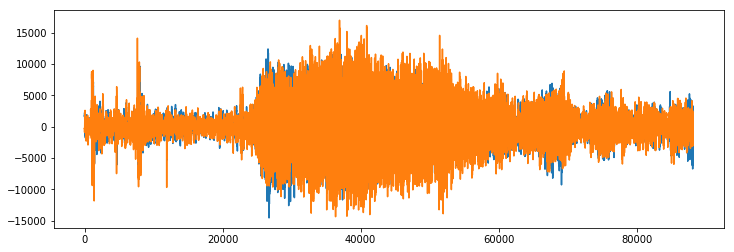

In [17]:
# We can observe the 2-Channel in the below graph
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

**Extract Features**

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [18]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [19]:
mfccs

array([[-320.1476   , -261.08688  , -202.14749  , ..., -214.13928  ,
        -201.59814  , -205.00516  ],
       [ 114.19032  ,  136.19568  ,  139.96779  , ...,  103.97069  ,
          96.21988  ,   89.64292  ],
       [  -4.0676255,  -14.809974 ,  -10.836107 , ...,  -54.266144 ,
         -63.0997   ,  -61.794174 ],
       ...,
       [   2.5702   ,   -3.8886971,  -10.503183 , ...,  -10.559733 ,
         -16.62359  ,  -18.355232 ],
       [   1.7429783,   -2.039968 ,   -5.2020736, ...,    5.0258846,
           2.7430224,    3.7191596],
       [  -1.5989988,    5.2587314,    4.5992265, ...,   11.174133 ,
           7.616271 ,    7.095308 ]], dtype=float32)

In [20]:
# Extracting MFCC's For every audio file

import os

audio_dataset_path = "audio"

In [21]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [22]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3553it [02:00, 29.10it/s]C:\Users\jaide\AppData\Roaming\Python\Python36\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8323it [04:34, 41.68it/s]C:\Users\jaide\AppData\Roaming\Python\Python36\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\jaide\AppData\Roaming\Python\Python36\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [04:46, 30.48it/s]


In [23]:
#converting extracted_feature to Pandas Dataframe

extracted_features_df = pd.DataFrame(extracted_features,columns=["feature","class"])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [24]:
#Split the dataset into independent and dependent dataset

X = np.array(extracted_features_df["feature"].tolist())
y = np.array(extracted_features_df["class"].tolist())

In [25]:
X.shape

(8732, 40)

In [26]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [27]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [28]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [30]:
X_train

array([[-1.3110471e+02,  1.1250591e+02, -2.2574696e+01, ...,
         3.2466526e+00, -1.3690237e+00,  2.7557542e+00],
       [-1.3670342e+01,  9.1085083e+01, -7.7927337e+00, ...,
        -3.2530508e+00, -5.2774529e+00, -1.5569714e+00],
       [-4.9871544e+01,  2.6535299e-01, -2.0500937e+01, ...,
         2.8545945e+00, -1.6092044e+00,  3.5248058e+00],
       ...,
       [-4.2701236e+02,  9.2623047e+01,  3.1293974e+00, ...,
         7.4264121e-01,  7.3349088e-01,  7.1100914e-01],
       [-1.4575461e+02,  1.3626578e+02, -3.3515522e+01, ...,
         1.4681193e+00, -2.0091701e+00, -8.8218188e-01],
       [-4.2103134e+02,  2.1065454e+02,  3.4906609e+00, ...,
        -5.3888674e+00, -3.3713605e+00, -1.5665114e+00]], dtype=float32)

In [31]:
X_train.shape

(6985, 40)

In [32]:
X_test.shape

(1747, 40)

In [33]:
y_train.shape

(6985, 10)

In [34]:
y_test.shape

(1747, 10)

In [35]:
metadata["class"].unique()


array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

**Model Creation**

In [36]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [38]:
### No of classes
num_labels=y.shape[1]

In [39]:
#ANN

model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [41]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [55]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
207/219 [===========================>..] - ETA: 0s - loss: 0.8571 - accuracy: 0.7252
Epoch 00001: val_loss improved from inf to 0.72652, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8603 - accuracy: 0.7247 - val_loss: 0.7265 - val_accuracy: 0.7796
Epoch 2/200
204/219 [==========================>...] - ETA: 0s - loss: 0.8728 - accuracy: 0.7168
Epoch 00002: val_loss improved from 0.72652 to 0.71386, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8716 - accuracy: 0.7152 - val_loss: 0.7139 - val_accuracy: 0.7871
Epoch 3/200
211/219 [===========================>..] - ETA: 0s - loss: 0.8852 - accuracy: 0.7125
Epoch 00003: val_loss improved from 0.71386 to 0.69711, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8811 - accuracy: 0.7141 - val_loss: 0.6971 - val_accu

200/219 [==========================>...] - ETA: 0s - loss: 0.8552 - accuracy: 0.7152
Epoch 00029: val_loss did not improve from 0.68914
219/219 [==============================] - 0s 2ms/step - loss: 0.8557 - accuracy: 0.7177 - val_loss: 0.6980 - val_accuracy: 0.7848
Epoch 30/200
215/219 [============================>.] - ETA: 0s - loss: 0.8876 - accuracy: 0.7166
Epoch 00030: val_loss did not improve from 0.68914
219/219 [==============================] - 0s 2ms/step - loss: 0.8868 - accuracy: 0.7171 - val_loss: 0.6996 - val_accuracy: 0.7790
Epoch 31/200
212/219 [============================>.] - ETA: 0s - loss: 0.8683 - accuracy: 0.7140
Epoch 00031: val_loss did not improve from 0.68914
219/219 [==============================] - 0s 2ms/step - loss: 0.8711 - accuracy: 0.7135 - val_loss: 0.7093 - val_accuracy: 0.7808
Epoch 32/200
205/219 [===========================>..] - ETA: 0s - loss: 0.8772 - accuracy: 0.7160
Epoch 00032: val_loss did not improve from 0.68914
219/219 [===============

Epoch 58/200
208/219 [===========================>..] - ETA: 0s - loss: 0.8675 - accuracy: 0.7237
Epoch 00058: val_loss did not improve from 0.67155
219/219 [==============================] - 0s 2ms/step - loss: 0.8702 - accuracy: 0.7223 - val_loss: 0.6857 - val_accuracy: 0.7928
Epoch 59/200
207/219 [===========================>..] - ETA: 0s - loss: 0.8748 - accuracy: 0.7120
Epoch 00059: val_loss did not improve from 0.67155
219/219 [==============================] - 0s 2ms/step - loss: 0.8761 - accuracy: 0.7114 - val_loss: 0.6874 - val_accuracy: 0.7859
Epoch 60/200
204/219 [==========================>...] - ETA: 0s - loss: 0.8578 - accuracy: 0.7232
Epoch 00060: val_loss did not improve from 0.67155
219/219 [==============================] - 0s 2ms/step - loss: 0.8606 - accuracy: 0.7227 - val_loss: 0.6751 - val_accuracy: 0.7968
Epoch 61/200
204/219 [==========================>...] - ETA: 0s - loss: 0.8545 - accuracy: 0.7135
Epoch 00061: val_loss did not improve from 0.67155
219/219 [==

Epoch 87/200
206/219 [===========================>..] - ETA: 0s - loss: 0.8531 - accuracy: 0.7203
Epoch 00087: val_loss did not improve from 0.66498
219/219 [==============================] - 0s 2ms/step - loss: 0.8504 - accuracy: 0.7205 - val_loss: 0.6835 - val_accuracy: 0.7876
Epoch 88/200
201/219 [==========================>...] - ETA: 0s - loss: 0.8619 - accuracy: 0.7198
Epoch 00088: val_loss did not improve from 0.66498
219/219 [==============================] - 0s 2ms/step - loss: 0.8585 - accuracy: 0.7204 - val_loss: 0.6902 - val_accuracy: 0.7819
Epoch 89/200
210/219 [===========================>..] - ETA: 0s - loss: 0.8478 - accuracy: 0.7269
Epoch 00089: val_loss did not improve from 0.66498
219/219 [==============================] - 0s 2ms/step - loss: 0.8510 - accuracy: 0.7263 - val_loss: 0.6955 - val_accuracy: 0.7865
Epoch 90/200
202/219 [==========================>...] - ETA: 0s - loss: 0.8607 - accuracy: 0.7232
Epoch 00090: val_loss improved from 0.66498 to 0.66111, saving

Epoch 116/200
205/219 [===========================>..] - ETA: 0s - loss: 0.8381 - accuracy: 0.7255
Epoch 00116: val_loss did not improve from 0.66045
219/219 [==============================] - 0s 2ms/step - loss: 0.8373 - accuracy: 0.7261 - val_loss: 0.6753 - val_accuracy: 0.7911
Epoch 117/200
206/219 [===========================>..] - ETA: 0s - loss: 0.8436 - accuracy: 0.7303
Epoch 00117: val_loss did not improve from 0.66045
219/219 [==============================] - 0s 2ms/step - loss: 0.8388 - accuracy: 0.7319 - val_loss: 0.7015 - val_accuracy: 0.7928
Epoch 118/200
206/219 [===========================>..] - ETA: 0s - loss: 0.8326 - accuracy: 0.7231
Epoch 00118: val_loss did not improve from 0.66045
219/219 [==============================] - 0s 2ms/step - loss: 0.8342 - accuracy: 0.7231 - val_loss: 0.6731 - val_accuracy: 0.7997
Epoch 119/200
205/219 [===========================>..] - ETA: 0s - loss: 0.8207 - accuracy: 0.7332
Epoch 00119: val_loss did not improve from 0.66045
219/219

201/219 [==========================>...] - ETA: 0s - loss: 0.8333 - accuracy: 0.7229
Epoch 00145: val_loss did not improve from 0.66045
219/219 [==============================] - 0s 2ms/step - loss: 0.8417 - accuracy: 0.7213 - val_loss: 0.6815 - val_accuracy: 0.7899
Epoch 146/200
202/219 [==========================>...] - ETA: 0s - loss: 0.8273 - accuracy: 0.7338
Epoch 00146: val_loss did not improve from 0.66045
219/219 [==============================] - 0s 2ms/step - loss: 0.8354 - accuracy: 0.7293 - val_loss: 0.6810 - val_accuracy: 0.7939
Epoch 147/200
202/219 [==========================>...] - ETA: 0s - loss: 0.8410 - accuracy: 0.7256
Epoch 00147: val_loss did not improve from 0.66045
219/219 [==============================] - 0s 2ms/step - loss: 0.8404 - accuracy: 0.7257 - val_loss: 0.6894 - val_accuracy: 0.7865
Epoch 148/200
201/219 [==========================>...] - ETA: 0s - loss: 0.8202 - accuracy: 0.7383
Epoch 00148: val_loss did not improve from 0.66045
219/219 [============

Epoch 174/200
205/219 [===========================>..] - ETA: 0s - loss: 0.8223 - accuracy: 0.7381
Epoch 00174: val_loss did not improve from 0.65410
219/219 [==============================] - 0s 2ms/step - loss: 0.8195 - accuracy: 0.7379 - val_loss: 0.6621 - val_accuracy: 0.8025
Epoch 175/200
204/219 [==========================>...] - ETA: 0s - loss: 0.8334 - accuracy: 0.7307
Epoch 00175: val_loss did not improve from 0.65410
219/219 [==============================] - 0s 2ms/step - loss: 0.8388 - accuracy: 0.7297 - val_loss: 0.6663 - val_accuracy: 0.8048
Epoch 176/200
204/219 [==========================>...] - ETA: 0s - loss: 0.8383 - accuracy: 0.7338
Epoch 00176: val_loss did not improve from 0.65410
219/219 [==============================] - 0s 2ms/step - loss: 0.8420 - accuracy: 0.7324 - val_loss: 0.6885 - val_accuracy: 0.7922
Epoch 177/200
208/219 [===========================>..] - ETA: 0s - loss: 0.8272 - accuracy: 0.7303
Epoch 00177: val_loss did not improve from 0.65410
219/219

In [56]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.801946222782135


In [57]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [58]:
prediction_feature = features_extractor(filename)
prediction_feature = prediction_feature.reshape(1,-1)
model.predict_classes(prediction_feature)


array([2], dtype=int64)

In [59]:

prediction_feature.shape

(1, 40)

In [60]:
predictions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [61]:
metadata["class"].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [62]:
model.predict_classes(X_test)

array([5, 9, 4, ..., 1, 2, 9], dtype=int64)

**Testing Some Test Audio Data**

In [88]:
# from sklearn.preprocessing import LabelEncorder
from sklearn.preprocessing import LabelEncoder
import warnings


In [89]:
def output(filename):
    
    warnings.filterwarnings('ignore')
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label=model.predict_classes(mfccs_scaled_features)
    prediction_class = labelencoder.inverse_transform(predicted_label) 
    return prediction_class

In [90]:
## Children Playing
filename = "6902-2-0-7.wav"
output(filename)

array(['children_playing'], dtype='<U16')

In [91]:
## Dog_Bark
filename = "209672-3-8-0.wav"
output(filename)

array(['dog_bark'], dtype='<U16')

In [92]:
## AC
filename ="39970-9-0-108.wav"
output(filename)

array(['air_conditioner'], dtype='<U16')

In [93]:
## Music
filename = "36264-9-0-1.wav"
output(filename)

array(['street_music'], dtype='<U16')